1. Import Python Modules

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch
import SpaMask_F

2. Set Parameters

(1) k_cutoff: the number of the nearest neighbors for each spot for constructing the initial spatial graph 

(2) exp_cutoff : the number of the furthest neighbors for each spot for constructing the opponent spatial graph 

(3) mask_rate : the propotion of the masked spots in the masking strategy before the encoder

(4) replace_rate : the propotion of the masked spots in the re-masking strategy before the decoder

(5) alpha_l : the hyperparameter in sce loss function

In [2]:
k_cutoff = 6
exp_cutoff = 450
mask_rate = 0.3
replace_rate = 0.2
alpha_l = 1      

3. Read data and proprocessing ST data

In [3]:
SpaMask_F.set_seed(11)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

datapath='E:\\data\\151674\\'
count_file='filtered_feature_bc_matrix.h5'

# read data
adata = SpaMask_F.read_data(path=datapath, count_file=count_file, datatype='h5')
# get model input data 
dataX, edge = SpaMask_F.get_data_deladj(adata, k_cutoff = k_cutoff, exp_cutoff = exp_cutoff)
in_dim = dataX.size()[1]

4. Train the SpaMask model

In [4]:
# Train model
model = SpaMask_F.PreModel1(in_dim,
                            replace_rate,
                            mask_rate,
                            alpha_l)

model.to(device)
dataX = dataX.to(device)
edge = edge.to(device)

adata = SpaMask_F.Train_SpaMask(model, edge, dataX, adata)

100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


5. Domain Identification

In [5]:
# mclust
num_clust = 7 
adata = SpaMask_F.mclust_R(adata, used_obsm='hidden_re', num_cluster = num_clust)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [16]:
# quantitatively assessed the domain identidication accuracy
metapath = 'E:\\data\\151674'
adata = SpaMask_F.DLPFC_metadata(metapath, adata) 
nmi, ari = SpaMask_F.Accuracy_calculate(adata, "mclust", 'ground_truth')
print(ari)

0.6199691632582248


6. Domain Visualization

[<Axes: title={'center': 'Domain'}, xlabel='spatial1', ylabel='spatial2'>]

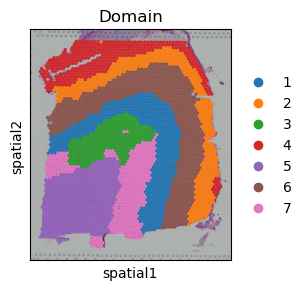

In [17]:
sc.pl.spatial(adata, img_key="hires", color='mclust', title='Domain', size=1.5, show=False)

7. Downstream analyses

7.1 UMAP Visualization

<Axes: title={'center': 'ground_truth'}, xlabel='UMAP1', ylabel='UMAP2'>

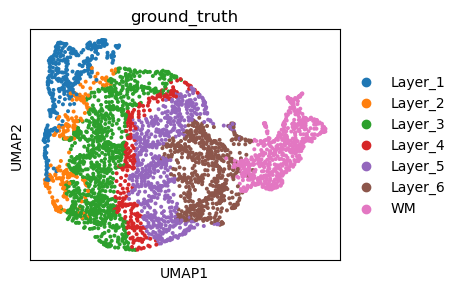

In [18]:
import anndata
hidden = adata.obsm['hidden_re']
hidden = anndata.AnnData(hidden)
hidden.obs_names = adata.obs_names
hidden.obs['ground_truth'] = adata.obs['ground_truth']

sc.pp.neighbors(hidden)
sc.tl.umap(hidden)
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.umap(hidden, color='ground_truth',  show=False)

7.2 PAGA Graph for trajectory analysis

<Axes: >

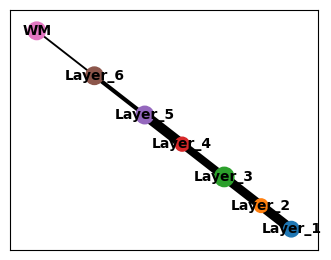

In [19]:
sc.tl.paga(hidden, groups='ground_truth')
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga(hidden, show=False)

7.3 Visualization of pseudo-Spatiotemporal Map (pSM)

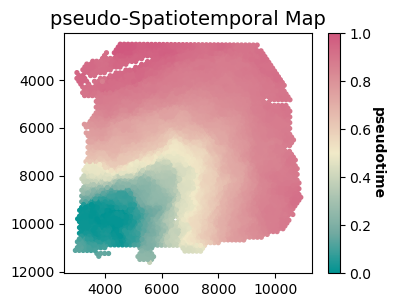

In [20]:
sc.tl.draw_graph(hidden,init_pos='paga')
hidden.uns['iroot'] = np.flatnonzero(hidden.obs['ground_truth']=='WM')[0]
sc.tl.diffmap(hidden)
sc.tl.dpt(hidden)

pSM_values = hidden.obs['dpt_pseudotime'].to_numpy()

def prepare_figure(rsz=3., csz=4., wspace=.4, hspace=.3, left=0.125, right=0.9, bottom=0.1, top=0.9):
    fig, axs = plt.subplots(1, 1, figsize=(csz, rsz))
    plt.subplots_adjust(wspace=wspace, hspace=hspace, left=left, right=right, bottom=bottom, top=top)
    return fig, axs

from palettable.cartocolors.diverging import TealRose_7
colormap = TealRose_7.mpl_colormap
fig, ax = prepare_figure()
x, y = adata.obsm["spatial"][:, 0], adata.obsm["spatial"][:, 1]
st = ax.scatter(x, y, s=30, c=pSM_values, cmap=colormap, marker=".")


ax.invert_yaxis()
clb = fig.colorbar(st)
clb.ax.set_ylabel("pseudotime", labelpad=10, rotation=270, fontsize=10, weight='bold')
ax.set_title("pseudo-Spatiotemporal Map", fontsize=14)
ax.set_facecolor("none")

8. Save results

In [21]:
savepath = 'E:\\data\\'
sc.write(savepath + 'results_151674.h5ad', adata)